In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import librosa
import math

sys.path.append('vqvae')
from utils import inv_mu_law_numpy, mu_law_numpy, mu_law, inv_mu_law
from model import *

import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [71]:
sample_rate = 8000  # Hz
SAMPLE_DURATION = 0.32
sample_period = 1.0/sample_rate
times = np.arange(0.0, SAMPLE_DURATION, sample_period)
sample_size = int(sample_rate * SAMPLE_DURATION)

def make_base_sine_wav(F0):
    return np.sin(times * 2.0 * np.pi * F0)

def make_sine_waves(speaker_id):
    speaker_tone = np.random.randint(100*speaker_id, high=300*speaker_id)
    
    amplitudes = make_base_sine_wav(speaker_tone)
    
    if speaker_id == 1: 
        return amplitudes
    
    if speaker_id == 2:
        low, high = 40, 80
        n = 2
        sin_func = np.sin
    elif speaker_id == 3:
        low, high = 400, 800
        n = 8        
        sin_func = np.cos
        
    for i in range(n):
        F0 = np.random.randint(low, high=high)
        amplitudes += (sin_func(times * 2.0 * np.pi * F0))

    amplitudes /= n

    return amplitudes

In [72]:
speaker_size = 3
batch_size = 1
train_data_size = speaker_size * 30
test_data_size = 3
train_ids = [(i % speaker_size + 1) for i in range(train_data_size)]
train_data = [make_sine_waves(id) for id in train_ids]
test_ids = [(i % speaker_size + 1) for i in range(speaker_size * test_data_size)]
test_data = [make_sine_waves(id) for id in test_ids]

In [6]:
class BatchLoader:
    def __init__(self, batch_size, data, ids, shuffle=False):
        self.batch_size = batch_size
        self.data = data
        self.n_data = len(data)
        self.ids = np.array(ids)
        
        if shuffle:
            random_indices = np.random.permutation(self.n_data)
            self.data = self.data[random_indices]
            self.ids = self.ids[random_indices]
        
        self.idx = 0
        self.step_per_epoch = int(math.ceil(float(self.n_data)/self.batch_size))
    
    def get_epoch_step(self, epoch):
        return self.step_per_epoch * epoch
    
    def load(self):
        fr = self.idx
        to = self.idx + self.batch_size

        if to > self.n_data:
            self.idx = to % self.n_data
            n_remains = to - self.n_data
            to = self.n_data
        else:
            n_remains = 0
            self.idx = to
            
        data = self.data[fr:to]
        ids = self.ids[fr:to]
        if n_remains > 0:
            data = np.concatenate((data, self.data[:n_remains])) 
            ids = np.concatenate((ids, self.ids[:n_remains])) 
        
        return data, ids

In [7]:
wavdir = os.path.expanduser('./wavs_test')
if not os.path.exists(wavdir):
    os.makedirs(wavdir)   

In [8]:
tf.reset_default_graph()
net = VQVAE(batch_size=batch_size, sample_size=sample_size, q_factor=1, is_training=True, K=64,
            lr=0.001, use_gc=True, gc_cardinality=speaker_size+1, n_stack=3, max_dilation=8,
            residual_channels=64, dilation_channels=64, skip_channels=128, use_biases=True, 
            upsampling_method='nn')

padded_audio = tf.placeholder(dtype=tf.float32)
gc_batch = tf.placeholder(dtype=tf.int32)
raw_output = net.create_model(padded_audio, gc_batch)
loss, recon_loss = net.loss(raw_output)


In [9]:
step_per_log = 300
step_per_valid = 2000
step_per_save = 2000
n_epoch = 1000000
max_keep = 10

# with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
        
    _data = np.vstack(train_data).astype(np.float32)
    _data = _data.reshape(train_data_size, sample_size, 1)
    batchloader = BatchLoader(batch_size, _data, train_ids)
    
    _test_data = np.vstack(test_data).astype(np.float32)
    _test_data = _test_data.reshape(len(test_data), sample_size, 1)
    test_batchloader = BatchLoader(batch_size, _test_data, test_ids)
    
    avg_loss = 0
    last_avg_loss = 9999
    for step in range(1, batchloader.get_epoch_step(n_epoch)):
        mini_batch, mini_ids = batchloader.load()
        padded_mini_batch = np.pad(mini_batch, ((0, 0), (net.receptive_field - 1, 0), (0, 0)),'constant')        

        _loss, _target, a_lc, a_gc, _ = sess.run([recon_loss, net.encoded_input, net.lc, net.gc, net.train_op], 
                                    feed_dict={padded_audio:padded_mini_batch, gc_batch:mini_ids})
        
        avg_loss += _loss
        
        
        if step > 0 and (step % step_per_log) == 0:
            avg_loss /= step_per_log
            print(step, 'avg loss: {}'.format(avg_loss))
            last_avg_loss = avg_loss
            avg_loss = 0
            
            
        if step > 0 and (step % step_per_save) == 0:
            net.save(sess, wavdir, step)               
        
        if last_avg_loss < 1e-1 and step > 0 and (step % step_per_valid) == 0:
#         if step > 0 and (step % step_per_valid) == 0:
            
            labels = tf.placeholder(tf.float32)
            generated = tf.placeholder(tf.int32)
            encoded_gen = net.one_hot_gen(generated) + 1e-6
            gen_loss = -tf.reduce_mean(labels * tf.log(encoded_gen))
            
            seed_sample = np.argmax(_target[0, 0, :])
            waveform = net.generate_waveform(sess, sample_size, a_lc, a_gc, 
                                                seed=seed_sample, use_randomness=False)            
            
            _target = _target.reshape(-1, net.quantization_channels)
            _gen_loss  = sess.run(gen_loss, feed_dict={generated:waveform, labels:_target})
            print('\tgen_loss:', _gen_loss)
             
            gen_wav = inv_mu_law_numpy(waveform, quantization_channels=net.quantization_channels)
            gen_wav = np.reshape(gen_wav, [batch_size, -1])           
            
            for k in range(batch_size):
                _gen_wav = gen_wav[k, :]
                _gen_wav = np.reshape(_gen_wav, [-1])

                fname = os.path.join(wavdir, str(step) + '-' + str(k) + '.wav')
                librosa.output.write_wav(fname, _gen_wav, sample_rate)

                rm_number = step - max_keep * step_per_valid
                if rm_number > 0:
                    rm_fname = os.path.join(wavdir, str(rm_number) + '-' + str(k) + '.wav')
                    if os.path.exists(rm_fname):
                        os.remove(rm_fname)
                        
        if last_avg_loss < 1e-4:
            break

300 avg loss: 2.2307776742684653
600 avg loss: 1.2956824215579157
900 avg loss: 1.0682072298413066


KeyboardInterrupt: 

In [78]:
def plot(wav, title=None):
    plt.figure(figsize=(10,5))
    if title is not None:
        plt.title(title)
    plt.plot(wav)
    plt.show()      

def convert(src_id, use_randomness=False):
    src = test_data[src_id-1]
    IPython.display.display(Audio(src, rate=sample_rate))
    plot(src[:sample_size//2], "Source")
    for target_id in range(1, speaker_size+1):
        title = "Converted from source(Type-{}) to Type-{}".format(src_id, target_id)
        wav = vc.convert(target_id, src=src, use_randomness=use_randomness)
        IPython.display.display(Audio(wav, rate=sample_rate))        
        plot(wav[:sample_size//2], title)

In [85]:
tf.reset_default_graph()

net = VQVAE(batch_size=batch_size, sample_size=sample_size, q_factor=1, is_training=True, K=64,
            lr=0.001, use_gc=True, gc_cardinality=speaker_size+1, n_stack=3, max_dilation=8,
            residual_channels=64, dilation_channels=64, skip_channels=128, use_biases=True, 
            upsampling_method='nn')

checkpoint_path = os.path.join('./logs/simple_test_nn3', 'model.ckpt-70000')

vc = VoiceConverter(net, checkpoint_path, batch_size=1, 
                    sample_rate=sample_rate, sample_size=sample_size, 
                    session_config=tf.ConfigProto(device_count={'GPU': 0}))

Loading checkpoint: ./logs/simple_test_nn3/model.ckpt-70000
INFO:tensorflow:Restoring parameters from ./logs/simple_test_nn3/model.ckpt-70000


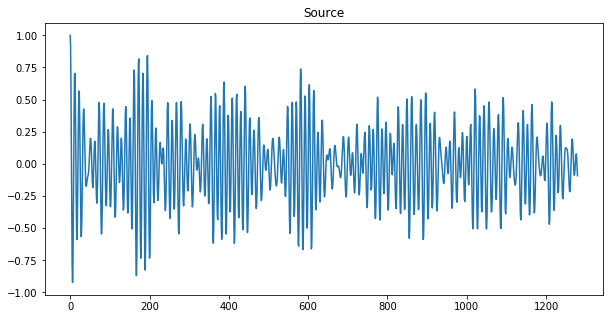

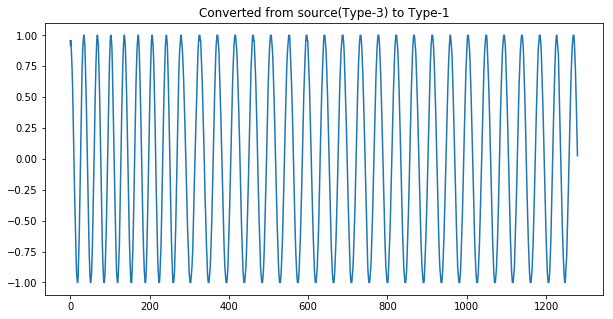

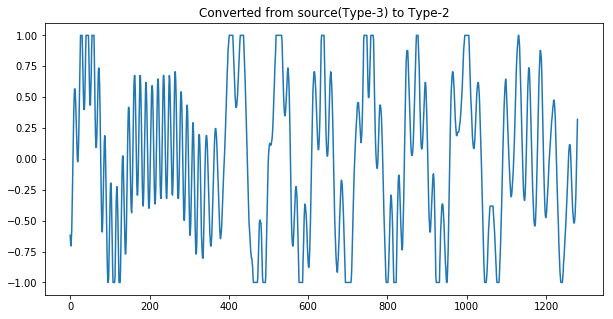

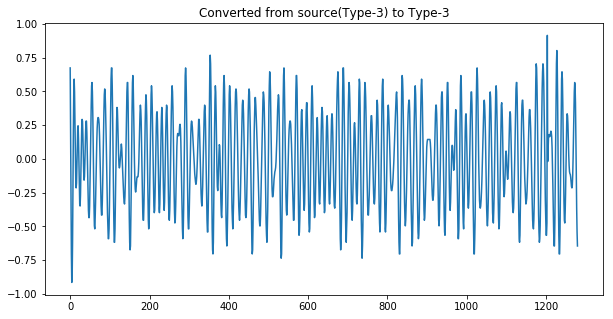

In [86]:
convert(3, use_randomness=False)